# Class-Conditional Synthesis with Latent Diffusion Models

# 경로 무조건 바꿔야 함!!!!!!

Install all the requirements

In [ ]:
#@title Installation
#한번만 실행하기!!!!!!
!git clone https://github.com/CompVis/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops

In [1]:
import sys
sys.path.append(".")
sys.path.append('./taming-transformers')

In [2]:
from taming.models import vqgan 

/home/Chaehyun/anaconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-07 19:16:05.737089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 19:16:05.861063: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 19:16:05.864275: W tensorflow/compiler/xla/stream_executor/platfor

Now, download the checkpoint (~1.7 GB). This will usually take 1-2 minutes.

In [3]:
#@title Download
#한번만 실행하기!!!!!!
%cd latent-diffusion/ 

!mkdir -p models/ldm/cin256-v2/
!wget -O models/ldm/cin256-v2/model.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt 

/home/Chaehyun/latent-diffusion/scripts/latent-diffusion
--2024-03-04 21:58:34--  https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt
Resolving ommer-lab.com (ommer-lab.com)... 141.84.41.65
Connecting to ommer-lab.com (ommer-lab.com)|141.84.41.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1827378153 (1.7G)
Saving to: ‘models/ldm/cin256-v2/model.ckpt’

models/ldm/cin256-v 100%[===================>]   1.70G  8.22MB/s    in 3m 40s  

2024-03-04 22:02:15 (7.94 MB/s) - ‘models/ldm/cin256-v2/model.ckpt’ saved [1827378153/1827378153]



Let's also check what type of GPU we've got.

In [3]:
!nvidia-smi

Tue Mar  5 13:48:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:19:00.0 Off |                  N/A |
| 30%   27C    P8              12W / 250W |      6MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Load it.

In [3]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model():
    ##############
    # 경로 바꾸기 #
    ##############
    config = OmegaConf.load("/home/Chaehyun/latent-diffusion/scripts/latent-diffusion/configs/latent-diffusion/cin256-v2.yaml")  
    model = load_model_from_config(config, "/home/Chaehyun/latent-diffusion/scripts/latent-diffusion/models/ldm/cin256-v2/model.ckpt")
    return model

In [4]:
from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model)

Loading model from /home/Chaehyun/latent-diffusion/scripts/latent-diffusion/models/ldm/cin256-v2/model.ckpt


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


And go. Quality, sampling speed and diversity are best controlled via the `scale`, `ddim_steps` and `ddim_eta` variables. As a rule of thumb, higher values of `scale` produce better samples at the cost of a reduced output diversity. Furthermore, increasing `ddim_steps` generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of `ddim_steps`) while retaining good quality can be achieved by using `ddim_eta = 0.0`.

rendering 6 examples of class '187' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


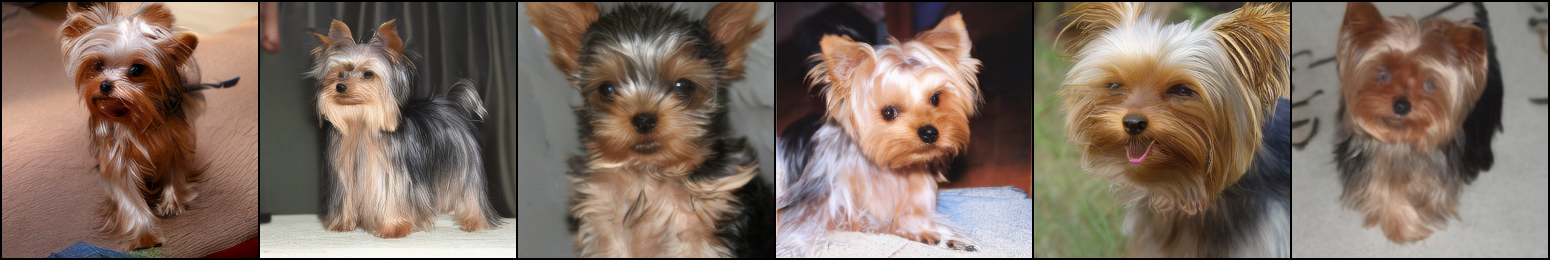

In [5]:
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid


classes = [187] #, 25, 448, 992]   # define classes to be sampled here
n_samples_per_class = 6

ddim_steps = 20
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance


all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.tensor(n_samples_per_class*[1000]).to(model.device)}
            )
        
        for class_label in classes:
            print(f"rendering {n_samples_per_class} examples of class '{class_label}' in {ddim_steps} steps and using s={scale:.2f}.")
            xc = torch.tensor(n_samples_per_class*[class_label])
            c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})
            
            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_class,
                                             shape=[3, 64, 64],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc, 
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

In [6]:
samples_ddim.shape

torch.Size([6, 3, 64, 64])

In [7]:
len(model.my_attn) # cc_attention, x, out -> dictionary

3

In [8]:
model.my_attn

{'cc_attention': [tensor([[[ 0.8944,  1.8085, -0.6928,  ..., -0.4498, -0.5359, -0.3331]],
  
          [[ 0.8944,  1.8085, -0.6928,  ..., -0.4498, -0.5359, -0.3331]],
  
          [[ 0.8944,  1.8085, -0.6928,  ..., -0.4498, -0.5359, -0.3331]],
  
          ...,
  
          [[ 0.2796,  0.3964,  0.0515,  ..., -1.3417,  1.0975,  0.4131]],
  
          [[ 0.2796,  0.3964,  0.0515,  ..., -1.3417,  1.0975,  0.4131]],
  
          [[ 0.2796,  0.3964,  0.0515,  ..., -1.3417,  1.0975,  0.4131]]],
         device='cuda:0'),
  tensor([[[ 0.8944,  1.8085, -0.6928,  ..., -0.4498, -0.5359, -0.3331]],
  
          [[ 0.8944,  1.8085, -0.6928,  ..., -0.4498, -0.5359, -0.3331]],
  
          [[ 0.8944,  1.8085, -0.6928,  ..., -0.4498, -0.5359, -0.3331]],
  
          ...,
  
          [[ 0.2796,  0.3964,  0.0515,  ..., -1.3417,  1.0975,  0.4131]],
  
          [[ 0.2796,  0.3964,  0.0515,  ..., -1.3417,  1.0975,  0.4131]],
  
          [[ 0.2796,  0.3964,  0.0515,  ..., -1.3417,  1.0975,  0.4131]]],
 

In [9]:
import matplotlib.pyplot as plt

In [10]:
model.my_attn['out'] # diffusion step, batch, channel, h ,w 

[tensor([[[[ 2.5391e-01, -4.2164e-01,  8.6396e-01,  ...,  5.2152e-01,
             6.0275e-01,  8.0166e-01],
           [-6.3164e-01,  7.3627e-02, -3.7587e-01,  ..., -2.1077e-01,
             9.6383e-01, -8.2586e-01],
           [ 1.1876e+00, -2.7768e-01, -1.6824e+00,  ..., -8.9521e-01,
            -1.4707e+00,  7.4483e-01],
           ...,
           [-1.9919e-01, -4.2895e-01,  8.3289e-01,  ...,  1.2642e+00,
            -5.9215e-01,  1.2840e+00],
           [ 6.1996e-01,  2.3160e-01, -6.9083e-02,  ..., -6.4285e-01,
             5.4817e-01, -5.6736e-01],
           [-1.3584e+00,  1.4135e-01,  5.1226e-02,  ..., -5.6228e-01,
            -3.6832e-02, -5.8783e-01]],
 
          [[-1.3790e+00, -3.1507e-01, -4.6129e-01,  ...,  5.4588e-02,
            -7.1055e-01, -7.3848e-01],
           [ 9.3276e-01,  9.5695e-01, -4.0217e-01,  ...,  2.2335e+00,
            -8.1317e-01,  5.6412e-01],
           [-9.7388e-01, -1.7720e-01,  6.1633e-01,  ...,  9.9157e-01,
             8.9627e-01, -1.0923e+00],


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

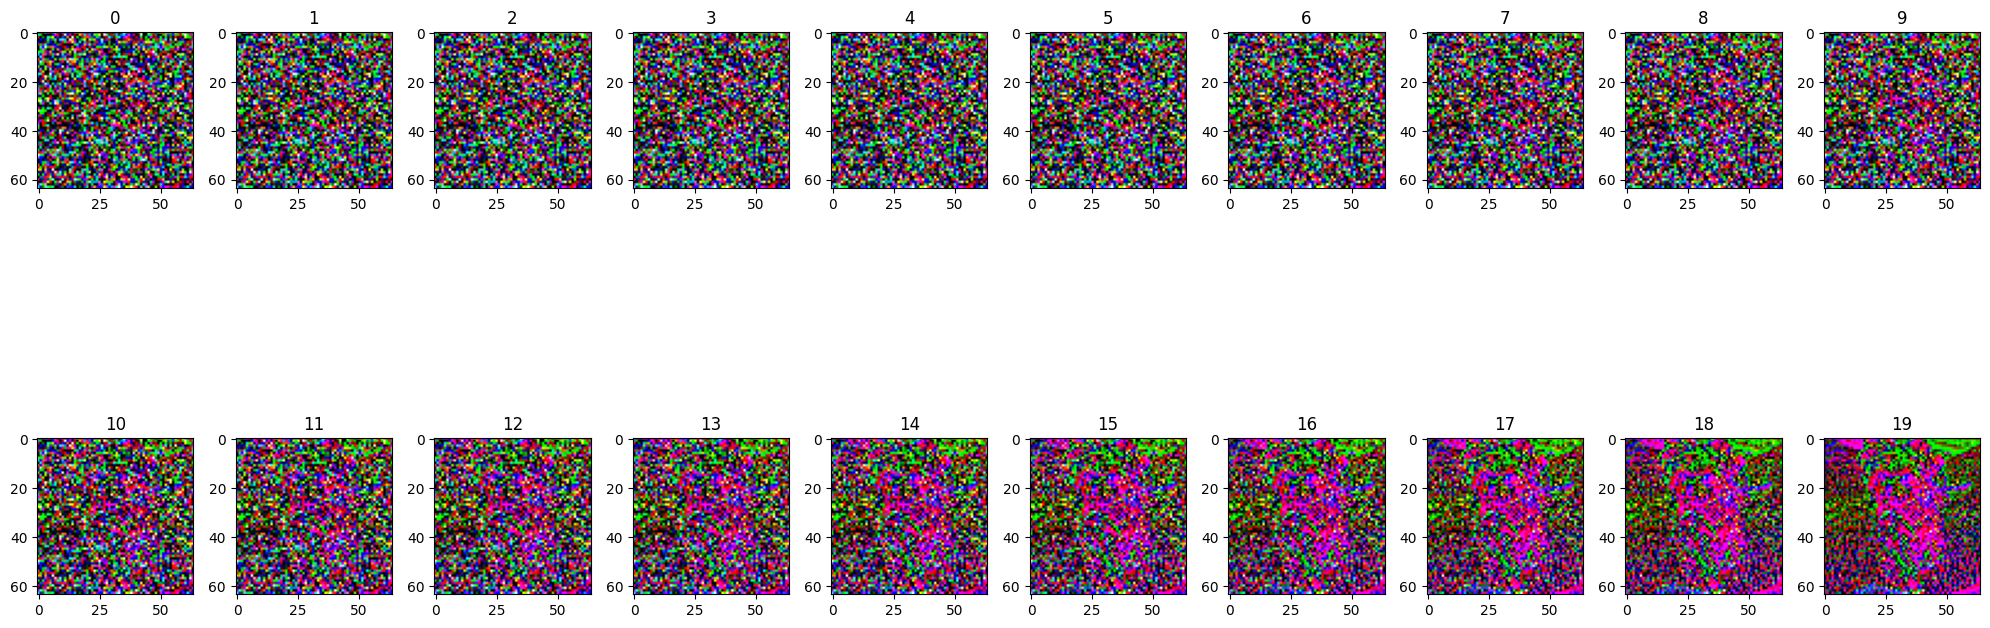

In [11]:
f,ax = plt.subplots(2,10,figsize=(20,10))
for i in range(2):
    for j in range(10):
        ax[i,j].imshow(model.my_attn['x'][i*10+ j][0].detach().cpu().permute(1,2,0).numpy())
        ax[i,j].set_title(i*10+j)
plt.tight_layout()
plt.show()

In [12]:
model.my_attn['cc_attention'][0].shape

torch.Size([12, 1, 512])

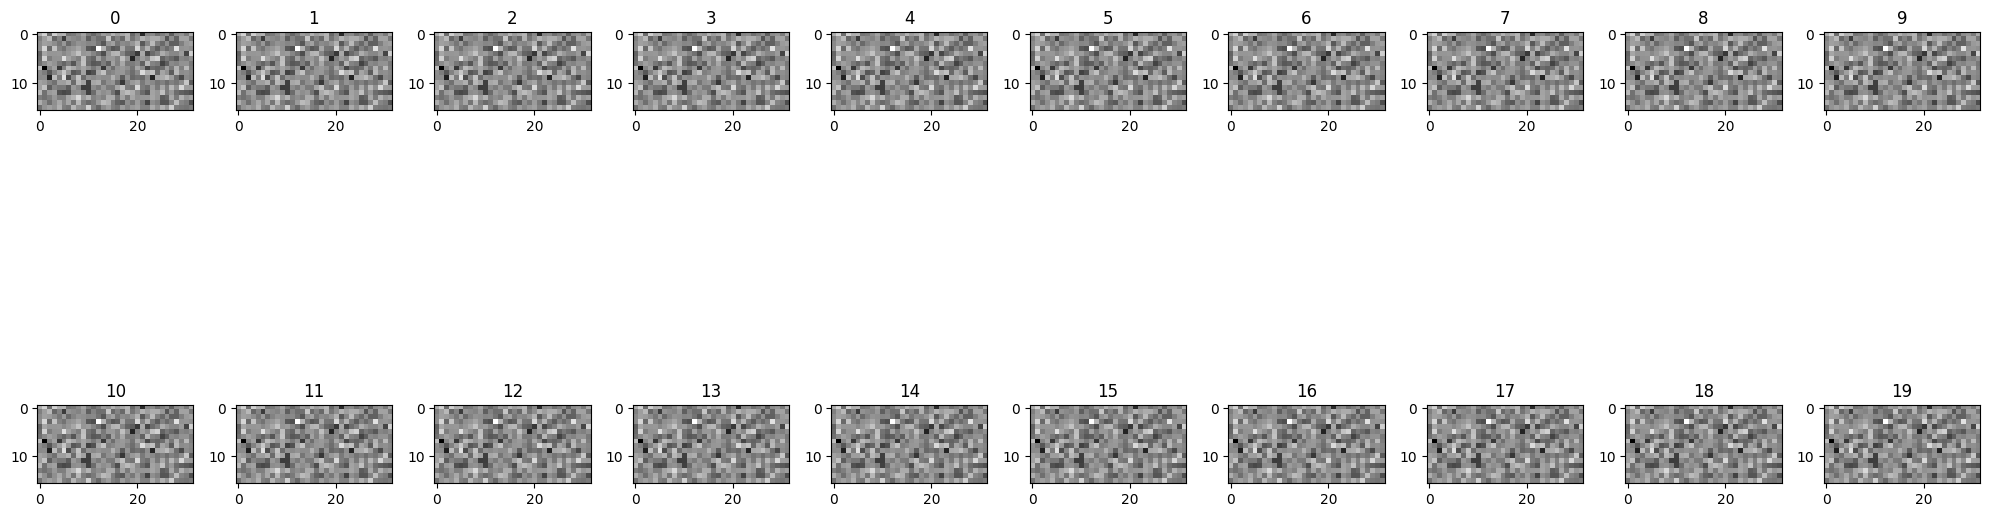

In [13]:
f,ax = plt.subplots(2,10,figsize=(20,10))
for i in range(2):
    for j in range(10):
        ax[i,j].imshow(model.my_attn['cc_attention'][i*10+j][0].detach().cpu().numpy().reshape(16,32), cmap='gray')
        ax[i,j].set_title(i*10+j)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

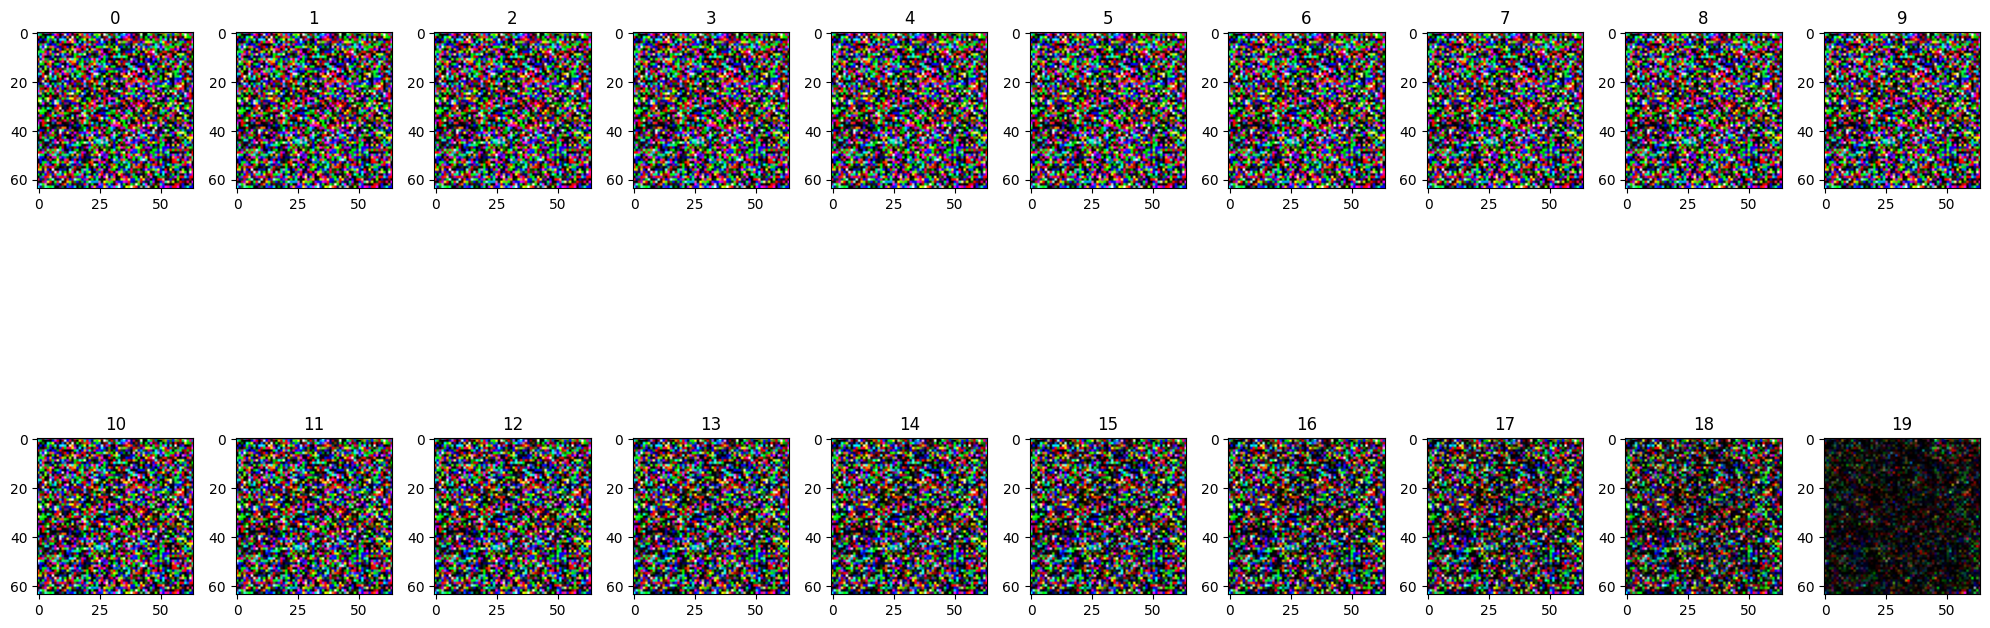

In [14]:
f,ax = plt.subplots(2,10,figsize=(20,10))
for i in range(2):
    for j in range(10):
        ax[i,j].imshow(model.my_attn['out'][i*10+ j][0].detach().cpu().permute(1,2,0).numpy())
        ax[i,j].set_title(i*10+j)
plt.tight_layout()
plt.show()

### decoder -  아직 못함

In [54]:
model.my_attn['out'][19].shape

torch.Size([12, 3, 64, 64])

In [78]:
all_samples = list()
x_samples_ddim = model.decode_first_stage(model.my_attn['out'][19])
x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
all_samples.append(x_samples_ddim)

In [79]:
all_samples[0].shape

torch.Size([12, 3, 256, 256])

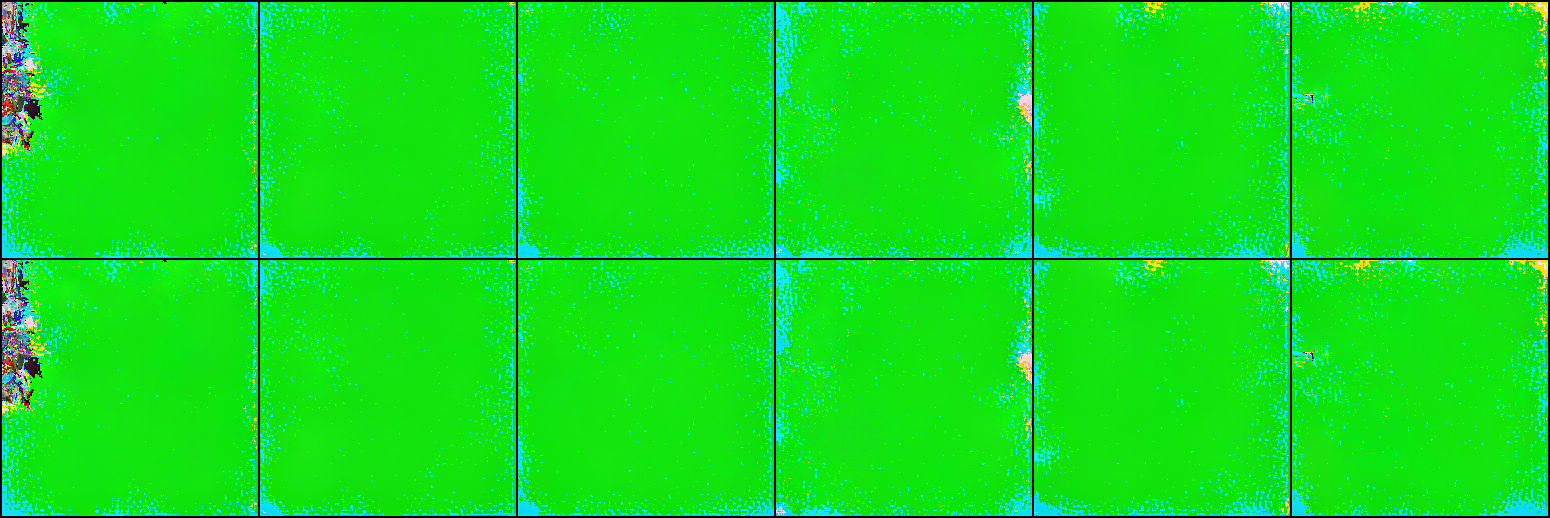

In [80]:
# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

### 분포

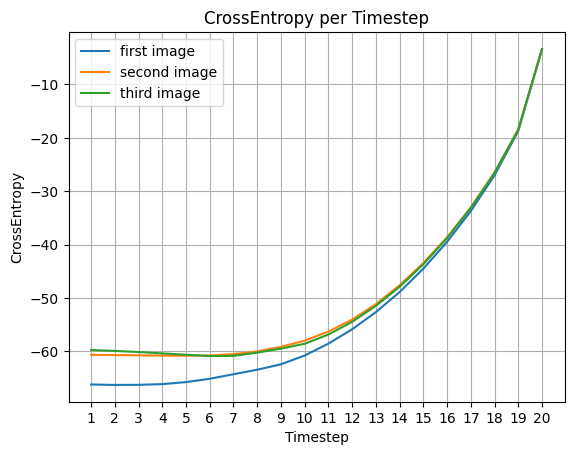

In [15]:
# x와 out의 분포 차이: CE
import torch
from typing import List

def CE(idx:int)->List[float]:
    criterion = torch.nn.CrossEntropyLoss()
    ce_list = []
    for i in range(2):
        for j in range(10):
            bin = criterion(model.my_attn['x'][i*10+ j][idx], model.my_attn['out'][i*10+ j][idx])
            ce_list.append(bin.cpu().numpy())
    return ce_list

ce_list1 = CE(0)
ce_list2 = CE(1)
ce_list3 = CE(2)

ce_list = [ce_list1, ce_list2, ce_list3]
x = range(1, 21)

# 각 ce_list를 plot으로 그리기
plt.plot(x, ce_list[0], label='first image')
plt.plot(x, ce_list[1], label='second image')
plt.plot(x, ce_list[2], label='third image')

plt.title('CrossEntropy per Timestep')
plt.xlabel('Timestep')
plt.ylabel('CrossEntropy')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 21))
plt.show()

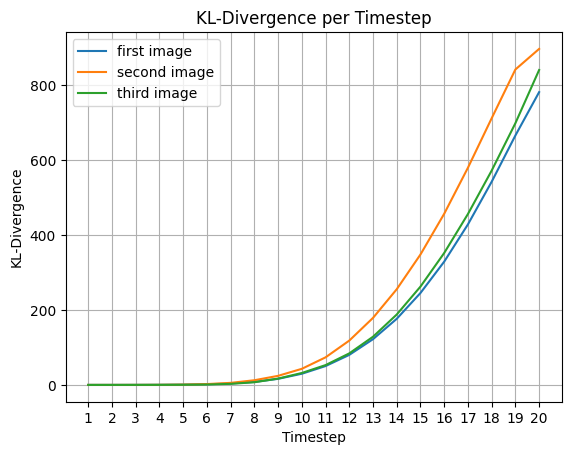

In [16]:
# KL divergence
def KL_D(x:torch.Tensor, out:torch.Tensor)->float:

    softmax = torch.nn.Softmax(dim=0)
    p = softmax(x)
    q = softmax(out)

    log_p = torch.log(p)
    log_q = torch.log(q)
    
    kl_divergence = torch.sum(p * (log_p - log_q))
    return kl_divergence.item()


def make_KL_for_images(idx:int)->List[float]:
    KL_list = []
    for i in range(2):
        for j in range(10):
            KL_list.append(KL_D(model.my_attn['x'][i*10+ j][idx], model.my_attn['out'][i*10+ j][idx]))

    return KL_list

kl_list1 = make_KL_for_images(0)
kl_list2 = make_KL_for_images(1)
kl_list3 = make_KL_for_images(2)

kl_list = [kl_list1, kl_list2, kl_list3]
x = range(1, 21)

# 각 kl_list를 plot으로 그리기
plt.plot(x, kl_list[0], label='first image')
plt.plot(x, kl_list[1], label='second image')
plt.plot(x, kl_list[2], label='third image')

plt.title('KL-Divergence per Timestep')
plt.xlabel('Timestep')
plt.ylabel('KL-Divergence')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 21))
plt.show()

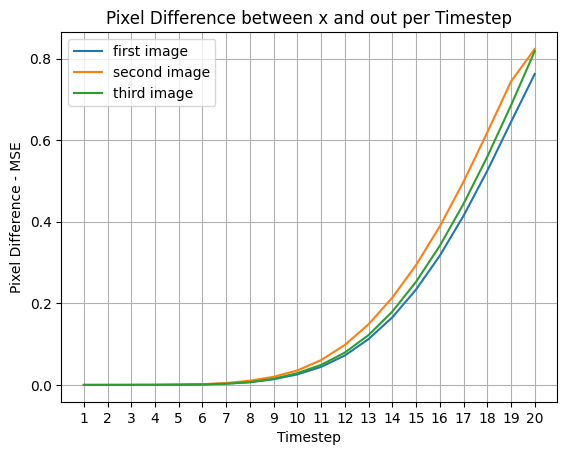

In [17]:
# 픽셀 차이: mse
# KL divergence
def mse_loss(x:torch.Tensor, out:torch.Tensor)->float:

    diff = out - x
    squared_diff = diff ** 2
    mse = torch.mean(squared_diff)
    
    return mse.item()


def pixel_difference(idx:int)->List[float]:
    mse_list = []
    for i in range(2):
        for j in range(10):
            mse_list.append(mse_loss(model.my_attn['x'][i*10+ j][idx], model.my_attn['out'][i*10+ j][idx]))

    return mse_list

mse_list1 = pixel_difference(0)
mse_list2 = pixel_difference(1)
mse_list3 = pixel_difference(2)

mse_list = [mse_list1, mse_list2, mse_list3]
x = range(1, 21)

# 각 kl_list를 plot으로 그리기
plt.plot(x, mse_list[0], label='first image')
plt.plot(x, mse_list[1], label='second image')
plt.plot(x, mse_list[2], label='third image')

plt.title('Pixel Difference between x and out per Timestep')
plt.xlabel('Timestep')
plt.ylabel('Pixel Difference - MSE')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 21))
plt.show()

### x와 out의 diffusion step마다의 분포

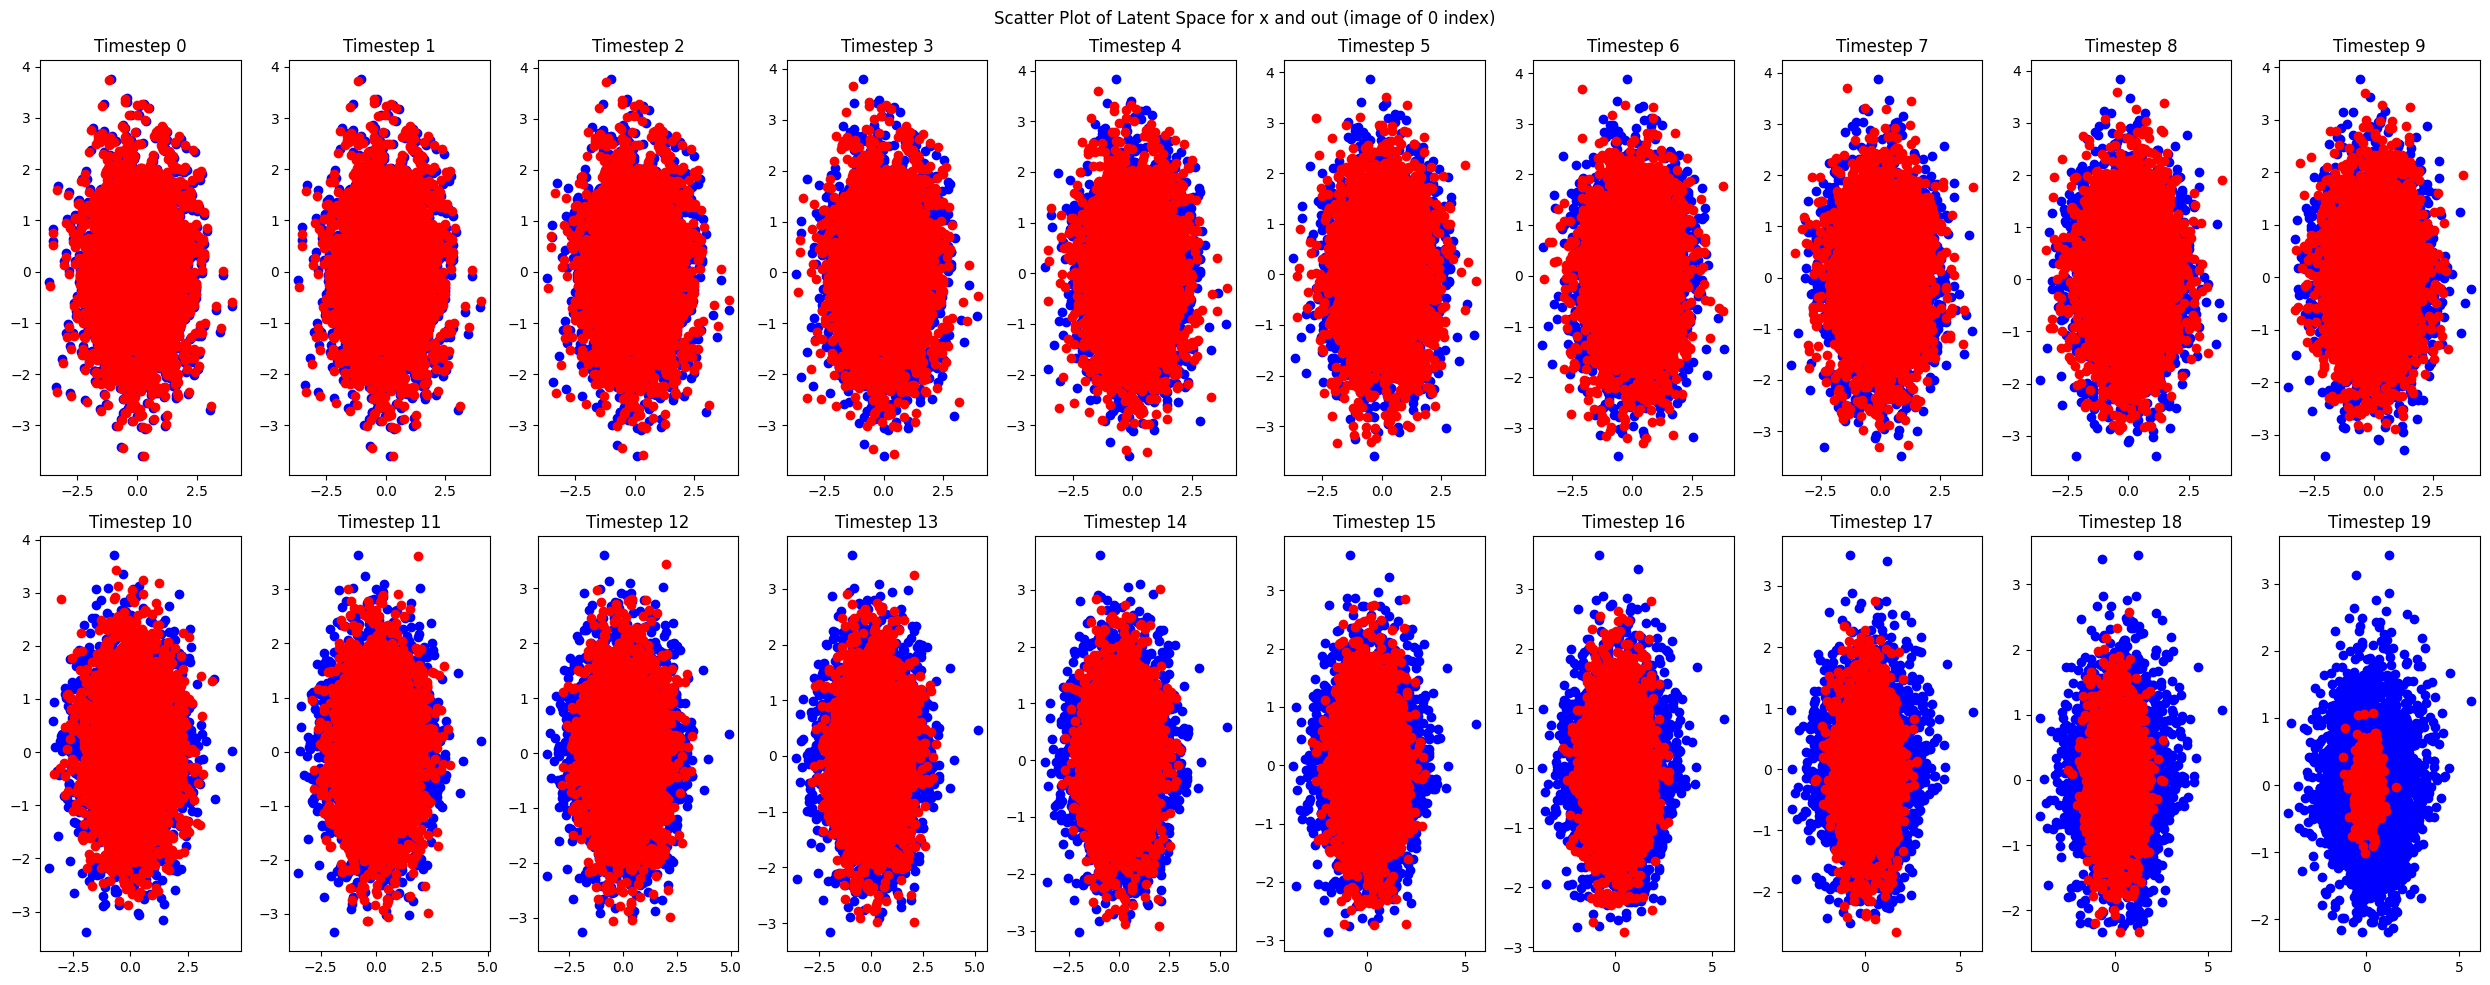

In [59]:
# using PCA
# 0번째 이미지에 대해서만 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

f,ax = plt.subplots(2,10,figsize=(25,10))

for i in range(2):
    for j in range(10):
        data_x = model.my_attn['x'][i*10+ j][0].detach().cpu().numpy().reshape(-1, 64*64)
        data_out = model.my_attn['out'][i*10+ j][0].detach().cpu().numpy().reshape(-1, 64*64)
        pca = PCA(n_components=2)
        data_2d_x = pca.fit_transform(data_x.T)
        data_2d_out = pca.fit_transform(data_out.T)

        ax[i,j].scatter(data_2d_x[:, 0], data_2d_x[:, 1], c='b', label='x')
        ax[i,j].scatter(data_2d_out[:, 0], data_2d_out[:, 1], c='r', label='out')
        ax[i,j].set_title('Timestep {}'.format(i*10 + j))

plt.suptitle('Scatter Plot of Latent Space for x and out (image of 0 index)')
plt.tight_layout()
plt.show()

1. 위에 한 것 out, x, cc 시각화 해보고 분석해보기
2. decoder 통과해보기 
3. x, out의 분포 차이 / 픽셀 차이 / bpd 계산....
4. x와 out의 diffusion step마다 t-sne 해보기 (x와 out이 같은 manifold 상에 있으면 좋겠다.)

noise와 image의 tsne가 다른지 확인해보기. 달라야 함(같은 manifold안에 noise와 pixel 두 개가 같이 존재하지 않는다.)
만약 둘이 비슷해 보인다면 같은 manifold안에 noise와 pixel 두 개가 같이 존재한다. 